In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import rasterio
from rasterio.plot import show

# Set the working directory
# Make sure to provide the appropriate path to your working directory
# Example: 
# os.chdir("C:/Users/user/Downloads/Flood ML/Red River Manitoba/")

# Bring in Flood Data (test/train)
data = pd.read_csv("Red_River_Flood_Samples.csv")
data.head()

# Check Pearson's Correlation
correlation_P = data.iloc[:, 2:10].corr(method="pearson")
correlation_P.to_csv("correlation_P.csv")
print(correlation_P.head())

# Check Variance Inflation Factors (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data.drop(["Flood_Binary", "Soil_types"], axis=1)
X = X.values
y = data["Flood_Binary"].values

vif = pd.DataFrame()
vif["Features"] = data.columns[2:10]
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(8)]
vif["VIF_pass"] = np.sqrt(vif["VIF"]) <= 2
print(vif)

# Remove Soil_types variable
data = data.drop("Soil_types", axis=1)

# Split dataset into 70% Training, 30% Testing data
train_size = int(0.7 * len(data))
train = data.sample(n=train_size, random_state=123)
test = data.drop(train.index)

# Gradient Boosting Machine
features = ["DEM_cut_rs", "River_dens", "Distance_t", "Land_use_2", "Curve_Stud", "Aspect_Stu", "Slope_Stud"]
target = "Flood_Binary"

# Fit GBM model
Gbm_model = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.05, max_depth=3, min_samples_leaf=10)
Gbm_model.fit(train[features], train[target])

# Test
TestPrediction = Gbm_model.predict_proba(test[features])[:, 1]

# Define a prediction score of >=0.6 as a flood (1), below 0.6 is a non-flood (0)
GBM_Flood = np.where(TestPrediction >= 0.6, 1, 0)





            DEM_cut_rs  Soil_types  River_dens  Distance_t  Land_use_2  \
DEM_cut_rs    1.000000   -0.018281   -0.019568    0.537554    0.062143   
Soil_types   -0.018281    1.000000    0.999996    0.066782   -0.001948   
River_dens   -0.019568    0.999996    1.000000    0.065608   -0.002172   
Distance_t    0.537554    0.066782    0.065608    1.000000    0.021009   
Land_use_2    0.062143   -0.001948   -0.002172    0.021009    1.000000   

            Curve_Stud  Aspect_Stu  Slope_Stud  
DEM_cut_rs   -0.224146   -0.262850   -0.320468  
Soil_types   -0.007681    0.005279    0.007662  
River_dens   -0.007584    0.006249    0.008794  
Distance_t   -0.012448   -0.288015   -0.287886  
Land_use_2   -0.030173   -0.095102   -0.204537  
     Features           VIF  VIF_pass
0  DEM_cut_rs      6.223801     False
1  Soil_types  10440.672487     False
2  River_dens      1.012425      True
3  Distance_t      3.406537      True
4  Land_use_2    106.454026     False
5  Curve_Stud      1.078677      

In [9]:
# Classification Accuracy
classification_accuracy = 1 - np.sum(np.abs(test[target] - GBM_Flood)) / len(GBM_Flood)
print(classification_accuracy)

# AUC
auc = roc_auc_score(test[target], TestPrediction)
print(auc)

0.8341666666666667
0.9050761802098151


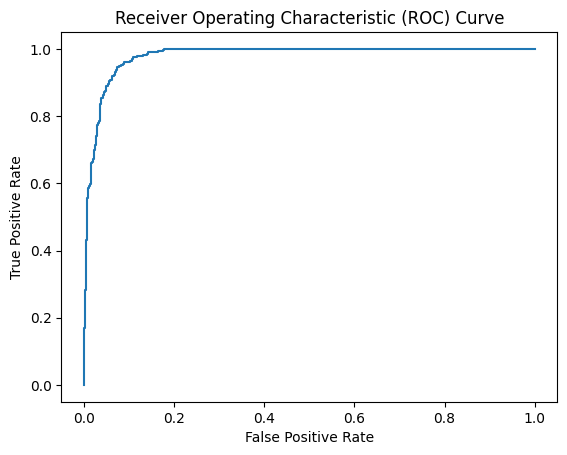

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_predictions)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()

In [11]:
# Creating Maps

# Load full dataset
XY_fix = pd.read_csv("C:/Users/user/Downloads/Flood ML/Red River Manitoba/FullData.csv")
fulldata = pd.read_csv("C:/Users/user/Downloads/Flood ML/Red River Manitoba/FullData_GBM_noSoil.csv")

# Predict using the GBM model on the full dataset
GBM_pred = Gbm_model.predict_proba(fulldata[features])[:, 1]


In [13]:
# Create the XYZ data
xyz_GBM = pd.DataFrame({"x": XY_fix["POINT_X"], "y": XY_fix["POINT_Y"], "Flood_suscept": GBM_pred})

# Convert XYZ data to raster
width = 1000
height = 1000
x_normalized = (xyz_GBM["x"] - xyz_GBM["x"].min()) / (xyz_GBM["x"].max() - xyz_GBM["x"].min()) * (width - 1)
y_normalized = (xyz_GBM["y"] - xyz_GBM["y"].min()) / (xyz_GBM["y"].max() - xyz_GBM["y"].min()) * (height - 1)
raster = np.zeros((height, width), dtype=np.float32)
for x_coord, y_coord, value in zip(x_normalized, y_normalized, xyz_GBM["Flood_suscept"]):
    raster[int(y_coord), int(x_coord)] = value

# Define the raster's extent
x_min = XY_fix["POINT_X"].min()
x_max = XY_fix["POINT_X"].max()
y_min = XY_fix["POINT_Y"].min()
y_max = XY_fix["POINT_Y"].max()

# Write the raster to a GeoTIFF file
with rasterio.open("GBM.tif", "w", driver="GTiff", width=width, height=height, count=1, dtype=np.float32,
                   crs="EPSG:4326", transform=rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, width, height)) as dst:
    dst.write(raster, 1)


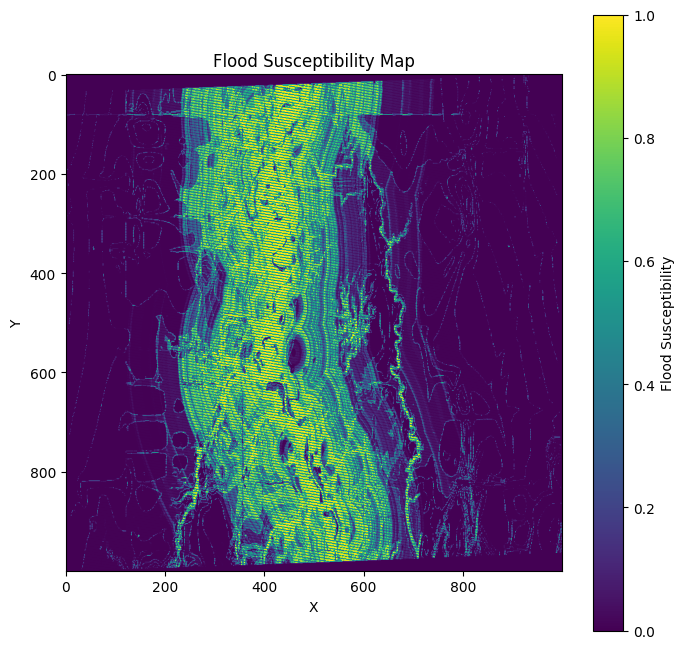

In [14]:
# Read the raster image
with rasterio.open("C:/Users/user/Downloads/Flood ML/Red River Manitoba/GBM.tif") as src:
    raster = src.read(1)

# Plot the raster image
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Flood Susceptibility')
plt.title('Flood Susceptibility Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

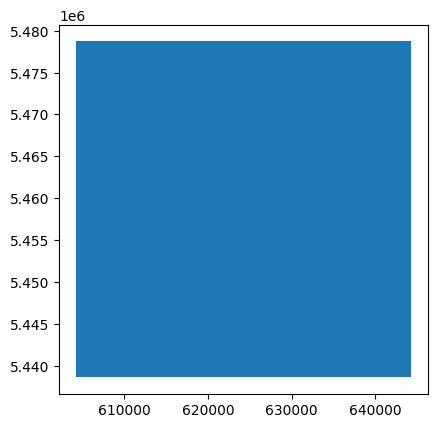

In [17]:
import geopandas as gpd
# Load the shapefile
shapefile_path = "C:/Users/user/Downloads/Flood ML/Red River Manitoba/Raw_Data/Raw_Data/Study_area.shp"
data = gpd.read_file(shapefile_path)

# Plot the shapefile
data.plot()
plt.show()